In [ ]:
from google.colab import userdata
import os
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

**Implement pix2pix model in order to take a google map satellite photo and build a street map.**

In [ ]:
!kaggle datasets download -d alincijov/pix2pix-maps

Dataset URL: https://www.kaggle.com/datasets/alincijov/pix2pix-maps
License(s): CC0-1.0
pix2pix-maps.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/pix2pix-maps.zip

Archive:  /content/pix2pix-maps.zip
replace train/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import tensorflow as tf

In [ ]:
import os
import time

IPython.display for controlling display outputs in a notebook environment rather than in a separate window, which is useful for tasks like plotting inline graphs or controlling display refreshes.

Helpful for clearing the output, displaying images, or updating plots in real-time during model training.

In [ ]:
from matplotlib import pyplot as plt
from IPython import display

In [ ]:
train_path = '/content/train/'
val_path = '/content/val/'

1. *BUFFER_SIZE*=400: This is commonly used for shuffling datasets. A buffer size of 400 means the dataset will shuffle 400 elements at a time.
2. OUTPUT_CHANNELS=3: This refers to the number of color channels in the output image. 3 usually represents RGB images (Red, Green, Blue channels).
3. LAMBDA is a weight factor used for the loss function. It balances the generator loss and the L1 loss between the predicted and target images (for pixel-to-pixel matching). A value of 100 indicates that the L1 loss is heavily weighted in the overall loss calculation

In [ ]:
BUFFER_SIZE=400
BATCH_SIZE=1
IMG_WIDTH=256
IMG_HEIGHT=256
OUTPUT_CHANNELS=3
LAMBDA=100

##Reading the Image File:
1. **tf.io.read_file(image_file)** reads the image data as raw bytes from the file path provided. (IMAGE->RAW BYTES)
2. **tf.image.decode_jpeg(image)** decodes the raw bytes into a JPEG image tensor. This works for .jpeg or .jpg images. If you're using another format like PNG, you can change it to tf.image.decode_png(image). (RAW BYTES-JPEG)

In [ ]:

def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]


  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

3. w = tf.shape(image)[1] gets the width of the image (since tf.shape(image) returns [height, width, channels]).
4. w = w // 2 divides the width by 2. This assumes that the input image and the target image are concatenated side by side horizontally.
5. real_image = image[:, :w, :] extracts the first half of the image (the "real" or target image).
6. input_image = image[:, w:, :] extracts the second half of the image (the "input" image that the model will transform)


The **resize function** resizes the input_image and real_image to a specified height and width using TensorFlow's tf.image.resize() function with the nearest neighbor *interpolation* method. This is useful for preparing images for training a model when a fixed input size is required

In [ ]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return input_image, real_image

The **random_crop function** then takes these two already split images and applies random cropping to both simultaneously, ensuring they remain aligned and maintain the same shape after cropping.

In [ ]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

The **normalize** function you've defined is designed to scale pixel values of the input and real images to a range of [-1, 1]. Normalization is an essential preprocessing step in many deep learning workflows, particularly for image-based models, as it helps stabilize and speed up the training process.*italicised text*

In [ ]:
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

The **random_jitter function** you've defined is a data augmentation technique that applies a series of transformations to the input and real images, including resizing, random cropping, and optional flipping. This function is particularly useful for improving the robustness of models by introducing variability in the training data.

In [ ]:
@tf.function()
def random_jitter(input_image, real_image):
  input_image, real_image = resize(input_image, real_image, 286, 286)

  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

The load_image_train function you've defined is designed to prepare images for training by loading them, applying data augmentation techniques, and normalizing the pixel values. This process is crucial for ensuring that your model receives appropriately processed input data during training.

In [ ]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)
  return input_image, real_image

The load_image_test function you provided is designed to prepare an image for testing (or inference) by loading it, resizing it to the required dimensions, and normalizing it. This process is important for ensuring that the input to your model during testing matches the preprocessing steps used during training.

In [ ]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image




The code snippet you've provided is for creating a TensorFlow dataset for training your model. This dataset will load images, apply preprocessing steps, shuffle them, and batch them for training.

In [ ]:
train_dataset = tf.data.Dataset.list_files(train_path + '*.jpg')
train_dataset = train_dataset.map(load_image_train,num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [ ]:
test_dataset = tf.data.Dataset.list_files(val_path + '*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

The code snippet you've provided imports TensorFlow and various components from the Keras API that are essential for building neural network models.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU , Dropout , ReLU ,Conv2DTranspose

The downsample function you’ve defined creates a sequential block of layers for downsampling an input feature map in a convolutional neural network (CNN). This is commonly used in architectures like GANs, autoencoders, or any model **that requires a reduction in spatial dimensions** while learning features.

In [ ]:
def downsample(filters, kernal_size, batch_norm=True):

    layer = Sequential()

    layer.add(Conv2D(filters, kernel_size=kernal_size, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))

    if batch_norm:
        layer.add(BatchNormalization())

    layer.add(LeakyReLU())

    return layer

The upsample function you've defined creates a sequential block of layers for upsampling an input feature map in a convolutional neural network (CNN). This is commonly used in architectures like GANs, autoencoders, or segmentation models where you need to increase the spatial dimensions of the feature maps

In [ ]:
def upsample(filters, kernal_size, dropout=False):

    layer=Sequential()
    layer.add(Conv2DTranspose(filters, kernel_size=kernal_size, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))

    layer.add(BatchNormalization())

    if dropout:
        layer.add(Dropout(0.4))

    layer.add(ReLU())

    return layer


The Generator function you've defined constructs a generator model, typically used in Generative Adversarial Networks (GANs) or image-to-image translation tasks. This generator uses an **encoder-decoder architecture with skip connections**, similar to a U-Net.

In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [
    downsample(64, 4, batch_norm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)

  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')

  x = inputs

  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

calling generator and below code snippet you provided will create a visual representation of your Generator model using TensorFlow's Keras utilities

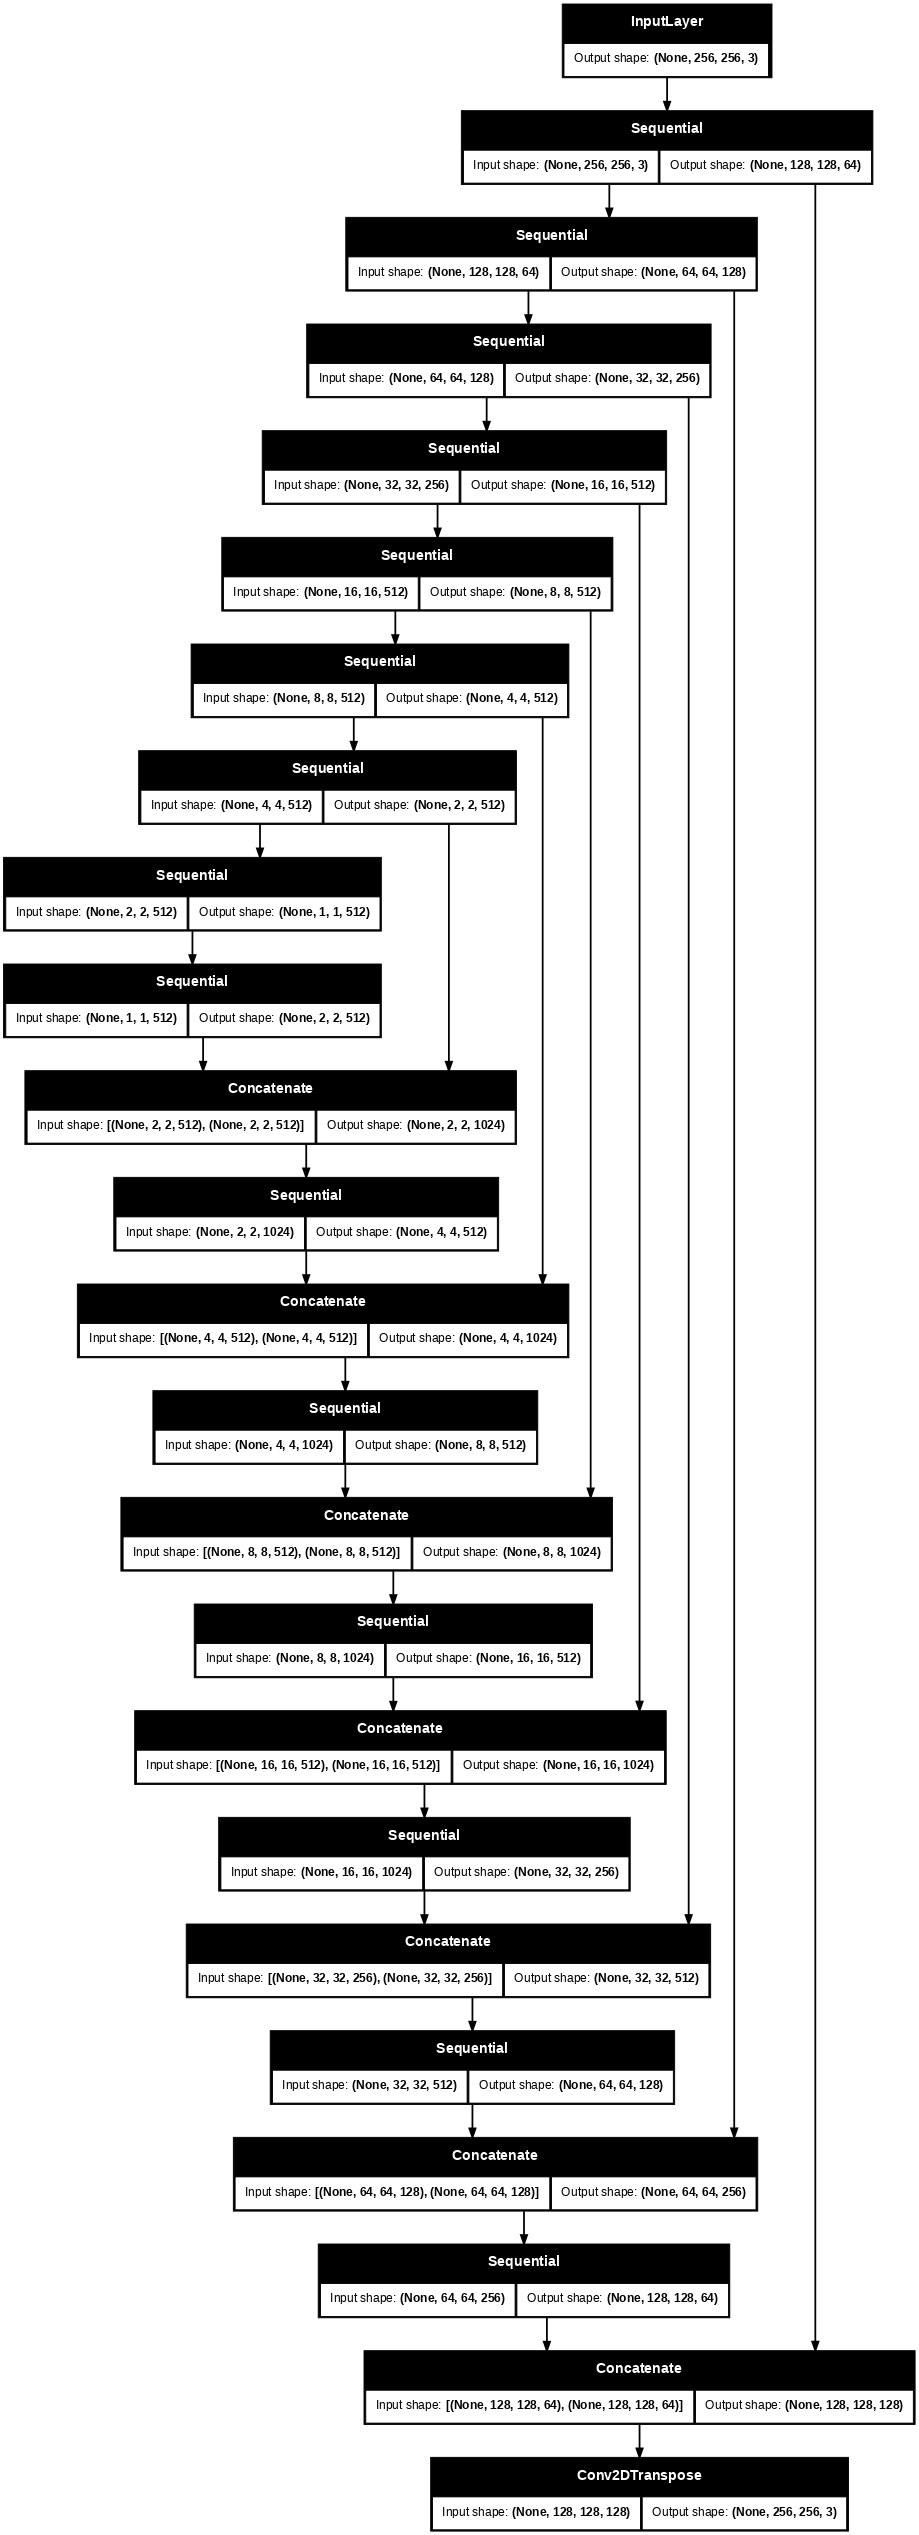

In [ ]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

The generator_loss function you've defined computes the **total loss for the generator** in a Generative Adversarial Network (GAN) setting, specifically when using a conditional GAN (cGAN) or a Pix2Pix style architecture.

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

The Discriminator function you provided constructs a discriminator model used in a Generative Adversarial Network (GAN) or a Pix2Pix architecture. This model evaluates whether the generated image is real (from the dataset) or fake (generated by the generator).

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)

  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

calling  discriminator and it will generate a visual representation of your Discriminator model using TensorFlow's Keras utilities.

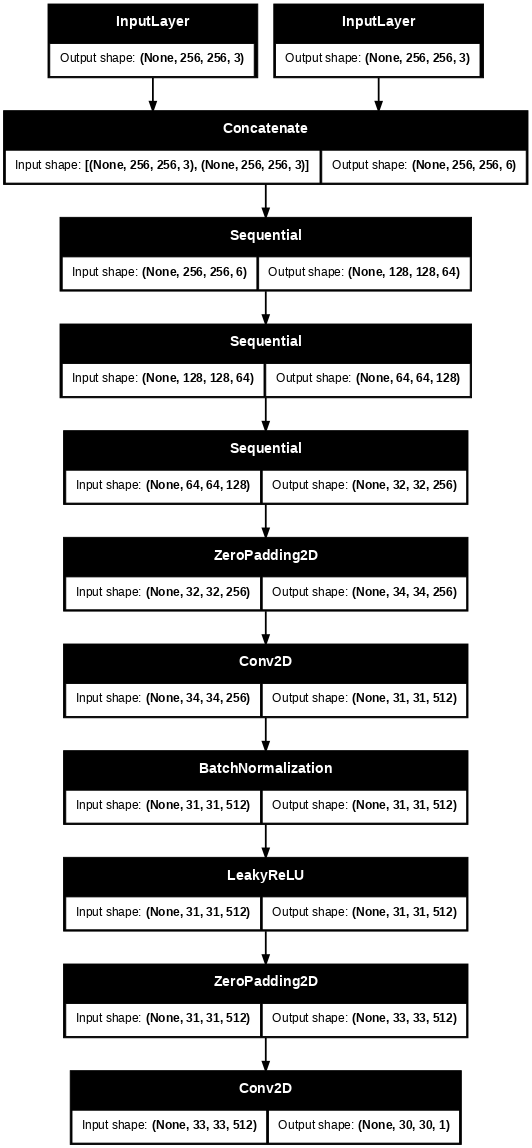

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

The discriminator_loss function you've defined calculates the total loss for the discriminator in a Generative Adversarial Network (GAN). This function helps the discriminator learn to differentiate between real and generated images effectively

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

The lines of code you've provided set up optimizers for the generator and discriminator in a Generative Adversarial Network (GAN). Let's break down each component:

Explanation of Each parameter

**Adam Optimizer:**
tf.keras.optimizers.Adam: This initializes an Adam optimizer, which is widely used in deep learning due to its adaptive learning rate properties.
Adam combines the advantages of two other extensions of stochastic gradient descent: AdaGrad and RMSProp.

**Learning Rate:**
2e-4: This sets the learning rate for the optimizer. A learning rate of
2
×
1
0
−
4
2×10
−4
  (or 0.0002) is a common choice for GANs, balancing the speed of convergence with stability.

**Beta Parameters:**
beta_1=0.5: This parameter controls the exponential decay rates for the first moment estimates. Setting beta_1 to 0.5 is a common practice in GAN training to help stabilize the training process. The default value for beta_1 in Adam is 0.9, but in GANs, lowering it can help reduce the effect of noisy updates.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

The line of code you've provided initializes a binary cross-entropy loss function with the from_logits=True parameter.

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

The generate_images function you've defined is designed to **visualize the input image, the ground truth (target) image, and the predicted image generated by your model**. This is especially useful for evaluating the performance of a GAN or any image-to-image translation model.

In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
EPOCHS = 1

The train_step function you defined is a key component of the training loop for a Generative Adversarial Network (GAN). **It manages the forward pass, computes losses, and updates the model weights based on the calculated gradients**.

In [ ]:
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

**The fit function you provided is designed to train your GAN model over a specified number of epochs**. It includes monitoring of the training process and visualizes generated images from the model at each epoch.

In [ ]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,time.time()-start))

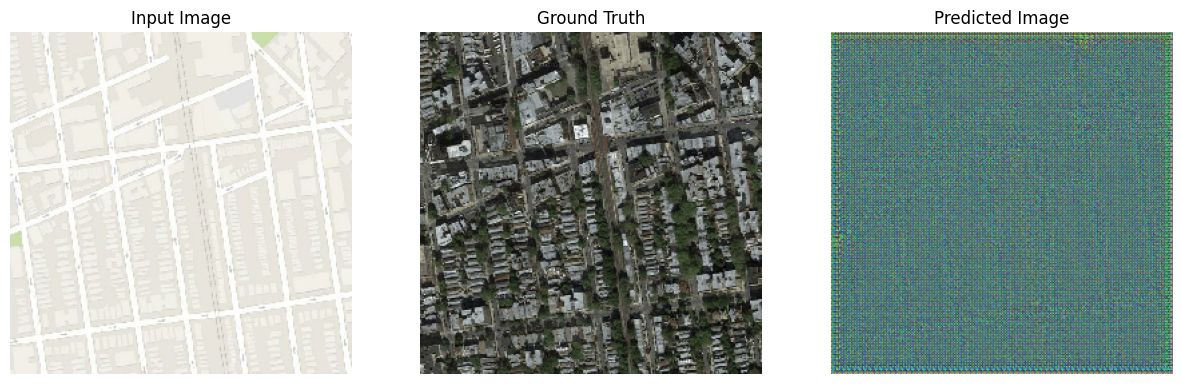

Epoch:  0
....................................................................................................
....................................................................................................
..................................................

In [ ]:
fit(train_dataset, EPOCHS, test_dataset)